In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys
sys.path.append('../')

from ast import literal_eval as make_tuple
from shared.utils.common import get_list_from_text_tuple, rotate_labels

## Loading data

In [4]:
df = pd.read_csv(
    '../shared/data/amz_products_small_pre_processed.csv.gz', 
    compression='gzip'
)

## Exploring Data

In [5]:
df.shape

(1229098, 10)

In [6]:
df_sampled = df.sample(frac=.01)   # not need to plot all 1M points

#### Main Category

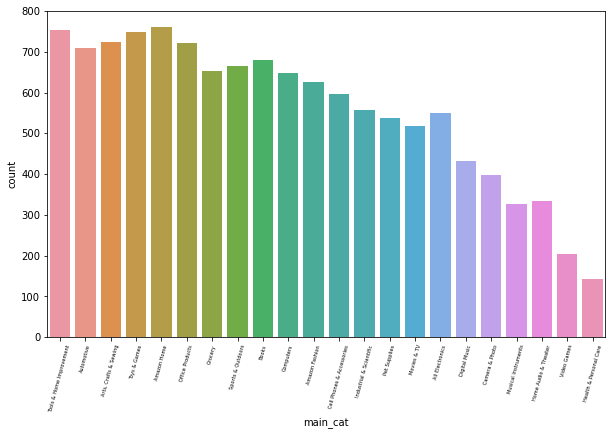

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

chart = sns.countplot(
    data=df_sampled, 
    x='main_cat', 
    ax=ax,
    order=df['main_cat'].value_counts().index
)

rotate_labels(chart)

We can see that there is a class imbalance. When we have this, we could do these different things for training the model:
- **Upsampling** the categories under-represented. This would increase computing power needed while training
- **Undersampling** the categories over-represented. This would mean for us to lose data.
- **Class weights**: in the loss criterion we could make that the loss of the under-represented categories is more meaningful than the ones over-represented.

#### Price

In [8]:
# Summary statistics (can see minimum is 0) 
df.price.describe()

count    643026.000000
mean         31.443036
std          63.423543
min           0.000000
25%           7.990000
50%          14.750000
75%          28.750000
max         999.990000
Name: price, dtype: float64

(0.0, 300.0)

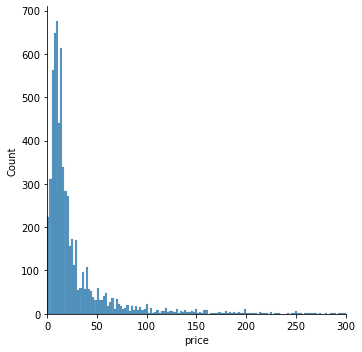

In [9]:
sns.displot(
    data=df_sampled, 
    x='price',
)

plt.xlim(0, 300)

We can assess if there is a difference in the price means depedending on which is the category that we have.

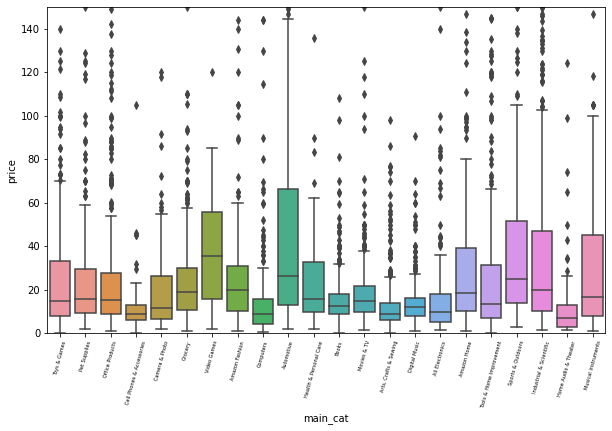

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

chart = sns.boxplot(
    data=df_sampled,
    y='price', 
    x='main_cat',
    ax=ax
)

plt.ylim(0, 150)
rotate_labels(chart)

There are a lot of outliers, but we can see that the distribution depending on the category changes.

We are going to do the **ANOVA** test, to confirm there is a significant difference in the mean of price across the main categories.

In [11]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Define the ANOVA model
model = ols('price ~ main_cat', data=df).fit()

# Perform ANOVA test
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the anova table
print(anova_table)

                sum_sq        df            F  PR(>F)
main_cat  1.136096e+08      21.0  1406.655048     0.0
Residual  2.472988e+09  643004.0          NaN     NaN


We are going to apply processing to the prices:
1. Fill the NaN prices by the median of its brand 
2. Convert to logarithms
3. MinMax Scale

In [12]:
from shared.model.data.features.engineering.price import BrandMapPriceMedian

In [13]:
brand_map_price_median = BrandMapPriceMedian(df=df)

In [14]:
# Compute price median by brands (some of brands are grouped in 'Other')
price_df = BrandMapPriceMedian(df).get_price_df()

In [15]:
# Could be done some pre-processing of which are the names of the brands
price_df.head()

,price_median
brand,
,15.99
(LEC),17.90
54-40,29.92
Bead,28.50
Gary Puckett & the Union Gap,19.35


In [17]:
# And now will work with the price feature 
from shared.model.data.features.engineering.price import Price

In [20]:
for idx, row in df_sampled.iterrows():
    df_sampled.loc[idx, 'price'] = Price(
        price_df=price_df,
    ).get_feature(row['price'], brand_name=row['brand'])

<AxesSubplot:>

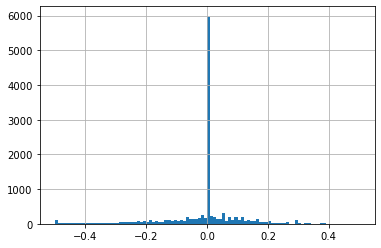

In [21]:
# And we will have the following distribution (between -.5, .5)
df_sampled.price.hist(bins=100)